# 1. Librerías y Configuración (AG GANN)

In [ ]:
!pip install swig
!pip install "gymnasium[box2d]" --no-deps
!pip install box2d imageio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 36.2 MB/s eta 0:00:00


In [ ]:
import gymnasium as gym
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import imageio
from typing import List, Tuple, Any
from IPython.display import Image, display

# 2. Parámetros del AG Cooperativo

Se definen dos conjuntos de parámetros para los dos AG que cooperan.
La arquitectura Binaria orientada a la arquitectura de la red, y la arquitectura Real para los pesos y bias.

In [ ]:
# --- PARÁMETROS DEL AG COOPERATIVO GANN ---

# Módulo de Diseño Arquitectónico (AG Binario) - El Bucle Principal
NUM_GENERATIONS = 40      # Generaciones del AG Binario
ARCH_POP_SIZE = 20         # Tamaño de la población de arquitecturas
ELITE_FRACTION_ARCH = 0.05  # Fracción de elitismo para arquitecturas
BIN_GEN_LENGTH = 5         # Longitud del gen binario (ej. para 2^8=256 arquitecturas)

# Módulo de Entrenamiento (AG Real) - El Sub-Proceso de Fitness
WEIGHT_AG_GENS = 40         # Generaciones de entrenamiento del AG Real por evaluación de arquitectura
WEIGHT_POP_SIZE = 20        # Tamaño de la población de pesos reales
ELITE_FRACTION_WEIGHTS = 0.05 # Fracción de elitismo para pesos
WEIGHT_MUTATION_RATE = 0.1
PATIENCE = 8

# Parámetros del Entorno
NUM_TRIALS = 5              # Pruebas de simulación para calcular el fitness de un conjunto de pesos
MAX_STEPS = 500             # Máximo de pasos por episodio
MAX_HIDDEN_NEURONS = 24     # Máximo de neuronas ocultas permitidas por el AG Binario

# Funciones para la Red Neuronal y su Decodificación

In [ ]:
def decodificar_neuronas_ocultas(bin_gen: List[int], max_h: int = MAX_HIDDEN_NEURONS) -> int:
    """Decodifica el gen binario para obtener H (número de neuronas ocultas)."""
    bits_needed = int(np.ceil(np.log2(max_h - 4 + 1)))
    bin_str = ''.join(map(str, bin_gen[:bits_needed]))
    decimal_val = int(bin_str, 2)
    H = 4 + (decimal_val % (max_h - 4 + 1))
    return H

def get_weight_size(input_size: int, output_size: int, H: int) -> int:
    """Calcula el número total de pesos/bias para la arquitectura H."""
    W1_size = input_size * H
    b1_size = H
    W2_size = H * output_size
    b2_size = output_size
    return W1_size + b1_size + W2_size + b2_size

def decode_real_weights(real_gen: List[float], input_size: int, output_size: int, H: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Decodifica el gen real (vector) en matrices de pesos y bias."""
    total_size = get_weight_size(input_size, output_size, H)
    if len(real_gen) != total_size:
        raise ValueError(f"Tamaño de gen real incorrecto: {len(real_gen)} != {total_size}")

    current = 0

    W1 = np.array(real_gen[current : current + input_size * H]).reshape(input_size, H)
    current += input_size * H

    b1 = np.array(real_gen[current : current + H])
    current += H

    W2 = np.array(real_gen[current : current + H * output_size]).reshape(H, output_size)
    current += H * output_size

    b2 = np.array(real_gen[current : current + output_size])

    return W1, b1, W2, b2

def forward(state: np.ndarray, W1: np.ndarray, b1: np.ndarray, W2: np.ndarray, b2: np.ndarray) -> int:
    """Pase hacia adelante de la red neuronal"""
    h_pre = np.dot(state, W1) + b1
    h_post = np.maximum(0, h_pre) # ReLU
    output_pre = np.dot(h_post, W2) + b2
    action = np.argmax(output_pre)
    return action

# 4. Módulo de Evaluación (Fitness)

Esta función es llamada por el **AG Real** para evaluar un conjunto de pesos en el entorno.

El fitness esta dado por la recompensa del entorno.

In [ ]:
def evaluate_fitness(real_gen: List[float], arquitectura_binaria: List[int], env: gym.Env, num_trials: int = NUM_TRIALS, max_steps: int = MAX_STEPS, render=False) -> float:
    """
    Evalúa el conjunto de pesos reales (real_gen) en el entorno,
    utilizando la arquitectura fija definida por arquitectura_binaria.
    """

    # 1. Obtener parámetros de la red
    input_size = env.observation_space.shape[0]
    output_size = env.action_space.n
    H = decodificar_neuronas_ocultas(arquitectura_binaria)

    # 2. Decodificar los pesos reales
    try:
        W1, b1, W2, b2 = decode_real_weights(real_gen, input_size, output_size, H)
    except ValueError:
        return -1000.0 # Fitness muy bajo si el genoma no coincide con la arquitectura

    total_rewards = []
    frames = []
    for _ in range(num_trials):
        observation, info = env.reset()
        episode_reward = 0
        terminated = False
        truncated = False
        steps = 0

        while not terminated and not truncated and steps < max_steps:
            action = forward(observation, W1, b1, W2, b2)
            observation, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward
            steps += 1
            if render:
                frames.append(env.render())

        total_rewards.append(episode_reward)
    if render:
        imageio.mimsave("lunarlander.gif", frames, fps=30)
        display(Image(filename="lunarlander.gif"))

    # El fitness es la recompensa promedio
    return np.mean(total_rewards)


# 5. Operadores Genéticos (AG Real - Pesos)

In [ ]:
def inicializar_poblacion_real(H: int, pop_size: int) -> List[List[float]]:
    """Inicializa una población de cromosomas reales (pesos) para una arquitectura H fija."""
    temp_env = gym.make('LunarLander-v3')
    size = get_weight_size(temp_env.observation_space.shape[0], temp_env.action_space.n, H)
    temp_env.close()
    return [np.random.uniform(-1.0, 1.0, size).tolist() for _ in range(pop_size)]

def cruce_blx_alpha(parent1: List[float], parent2: List[float], alpha: float = 0.5) -> List[float]:
    """Cruce BLX-alpha (Blended Crossover) para genes reales (devuelve un hijo)."""
    child = []
    for p1, p2 in zip(parent1, parent2):
        min_val = min(p1, p2)
        max_val = max(p1, p2)
        d = max_val - min_val

        # Calcular el rango extendido [I_min, I_max]
        I_min = min_val - alpha * d
        I_max = max_val + alpha * d

        # El hijo es un valor aleatorio uniforme en el rango extendido
        # Se clip a [-1.0, 1.0] para asegurar que esté dentro de los límites del genoma.
        new_gene = np.clip(random.uniform(I_min, I_max), -1.0, 1.0)
        child.append(new_gene)

    return child

def mutacion_gaussiana_adaptativa(gen: List[float], generation: int, max_gen: int, mutation_rate: float = 0.1) -> List[float]:
    """Mutación Gaussiana para genes reales (adaptativa/regular)."""
    sigma = 0.3 * (1 - generation / max_gen) + 0.05
    mutated_gen = list(gen)
    for i in range(len(mutated_gen)):
        if random.random() < mutation_rate:
            mutated_gen[i] += random.gauss(0, sigma)
            mutated_gen[i] = np.clip(mutated_gen[i], -1.0, 1.0)
    return mutated_gen

def seleccion_por_torneo(population: List[List[float]], fitnesses: List[float], k: int = 3) -> List[float]:
    """Selección por Torneo para obtener padres."""
    pop_indices = list(range(len(population)))
    participants = random.choices(pop_indices, k=k)
    winner_index = max(participants, key=lambda i: fitnesses[i])
    return population[winner_index]


def crear_nueva_generacion_real(old_population: List[List[float]], fitnesses: List[float], generation: int = 0, max_gen: int = WEIGHT_AG_GENS) -> List[List[float]]:
    """Crea la nueva generación del AG Real (Pesos)."""
    new_population = []
    elite_size = int(len(old_population) * ELITE_FRACTION_WEIGHTS)

    # Elitismo
    sorted_indices = np.argsort(fitnesses)[::-1]
    elite = [old_population[i] for i in sorted_indices[:elite_size]]
    new_population.extend(elite)

    # Reproducción
    while len(new_population) < len(old_population):
        parent1 = seleccion_por_torneo(old_population, fitnesses, k=3)
        parent2 = seleccion_por_torneo(old_population, fitnesses, k=3)

        child = cruce_blx_alpha(parent1, parent2, alpha=0.2)
        # Llamar con generation y max_gen
        child = mutacion_gaussiana_adaptativa(child, generation, max_gen)
        new_population.append(child)

    return new_population[:len(old_population)]

# 6. Módulo de Entrenamiento: AG Real (Sub-Proceso)

Esta función es el **Sub-Proceso de Entrenamiento**. Ejecuta un AG para encontrar los mejores pesos para una arquitectura y devuelve el fitness (máxima recompensa) que logra.

In [ ]:
weight_cache = {}

def run_real_ag_sub_process(arquitectura_binaria: List[int], env: gym.Env, num_trials: int, weight_ag_gens: int) -> Tuple[float, List[float]]:
    """
    Ejecuta el AG Real por un número limitado de generaciones para
    encontrar el mejor conjunto de pesos para la arquitectura_binaria.
    """

    # 1. Adaptar el genoma y obtener H
    H = decodificar_neuronas_ocultas(arquitectura_binaria)
    arch_key = tuple(arquitectura_binaria)

    # 2. Inicializar la población de pesos reales (tamaño fijo según H)
    if arch_key in weight_cache:
        # Reutilizar los mejores pesos previos
        best_prev_weights = weight_cache[arch_key]['weights']
        poblacion_pesos = inicializar_poblacion_real(H, WEIGHT_POP_SIZE)
        # Reemplazar algunos individuos con variaciones del mejor previo
        num_seeded = min(10, WEIGHT_POP_SIZE // 4)
        for i in range(num_seeded):
            # Añadir versiones mutadas del mejor previo (mutación más fuerte al inicio)
            poblacion_pesos[i] = mutacion_gaussiana_adaptativa(
                best_prev_weights,
                generation=0,  # Usamos gen 0 para tener alta exploración al recuperar del caché
                max_gen=weight_ag_gens,
                mutation_rate=0.15  # Mayor tasa de mutación al sembrar desde caché
            )
    else:
        poblacion_pesos = inicializar_poblacion_real(H, WEIGHT_POP_SIZE)

    mejor_fitness_pesos = -float('inf')
    mejor_gen_pesos = None

    # Variables para early stopping
    generations_without_improvement = 0
    fitness_threshold = 0.1  # Umbral mínimo de mejora considerada significativa

    # 3. Bucle del AG Real (Sub-Proceso de Entrenamiento)
    for gen in range(weight_ag_gens):
        # Evaluación
        fitnesses = [evaluate_fitness(gen_peso, arquitectura_binaria, env, num_trials)
                     for gen_peso in poblacion_pesos]

        # Registrar el mejor peso encontrado
        current_best_fitness = max(fitnesses)

        # Verificar si hay mejora significativa
        if current_best_fitness > mejor_fitness_pesos + fitness_threshold:
            # Hay mejora significativa
            mejor_fitness_pesos = current_best_fitness
            mejor_gen_pesos = poblacion_pesos[np.argmax(fitnesses)]
            generations_without_improvement = 0  # Reset del contador
        else:
            # No hay mejora significativa
            generations_without_improvement += 1
            # Actualizar el mejor si es mayor (aunque no sea significativo)
            if current_best_fitness > mejor_fitness_pesos:
                mejor_fitness_pesos = current_best_fitness
                mejor_gen_pesos = poblacion_pesos[np.argmax(fitnesses)]

        # Early stopping: detener si no hay mejora en PATIENCE generaciones
        if generations_without_improvement >= PATIENCE:
            break

        # Creación de la Nueva Generación de Pesos (pasar gen y max_gen)
        poblacion_pesos = crear_nueva_generacion_real(
            poblacion_pesos,
            fitnesses,
            generation=gen,           # ← Número de generación actual
            max_gen=weight_ag_gens    # ← Número total de generaciones
        )

    # Actualizar cache
    if arch_key not in weight_cache or mejor_fitness_pesos > weight_cache[arch_key]['fitness']:
        weight_cache[arch_key] = {
            'fitness': mejor_fitness_pesos,
            'weights': mejor_gen_pesos
        }

    # El fitness de la arquitectura es el mejor desempeño que se logró entrenar.
    return mejor_fitness_pesos, mejor_gen_pesos

# 7. Operadores Genéticos (AG Binario - Arquitecturas)

Estas funciones evolucionan las arquitecturas.

In [ ]:
def inicializar_poblacion_binaria(pop_size: int, gen_length: int = BIN_GEN_LENGTH) -> List[List[int]]:
    """Inicializa una población de cromosomas binarios (arquitecturas)."""
    return [np.random.randint(0, 2, gen_length).tolist() for _ in range(pop_size)]

def cruce_uniforme_binario(parent1: List[int], parent2: List[int]) -> Tuple[List[int], List[int]]:
    """Cruce Uniforme (Generalizado) para genes binarios."""
    child1 = []
    child2 = []
    for p1, p2 in zip(parent1, parent2):
        if random.random() < 0.5: # 50% de probabilidad de tomar del padre 1
            child1.append(p1)
            child2.append(p2)
        else: # 50% de probabilidad de tomar del padre 2
            child1.append(p2)
            child2.append(p1)
    return child1, child2

def mutacion_bit_flip(gen: List[int], mutation_rate: float = 0.01) -> List[int]:
    """Mutación Bit-Flip para genes binarios."""
    mutated_gen = list(gen)
    for i in range(len(mutated_gen)):
        if random.random() < mutation_rate:
            mutated_gen[i] = 1 - mutated_gen[i] # Flip el bit
    return mutated_gen

def crear_nueva_generacion_binaria(old_population: List[List[int]], fitnesses: List[float]) -> List[List[int]]:
    """Crea la nueva generación del AG Binario (Arquitecturas)."""
    new_population = []
    elite_size = int(len(old_population) * ELITE_FRACTION_ARCH)

    # 1. Elitismo
    sorted_indices = np.argsort(fitnesses)[::-1]
    elite = [old_population[i] for i in sorted_indices[:elite_size]]
    new_population.extend(elite)

    # 2. Reproducción
    parents = seleccion_por_torneo(old_population, fitnesses)

    while len(new_population) < len(old_population):
        # Elegir dos padres (simplificado)
        parent1 = seleccion_por_torneo(old_population, fitnesses, k=3)
        parent2 = seleccion_por_torneo(old_population, fitnesses, k=3)

        # Cruce UNIFORME BINARIO
        child1, _ = cruce_uniforme_binario(parent1, parent2)

        # Mutación
        child1 = mutacion_bit_flip(child1)
        new_population.append(child1)

    return new_population[:len(old_population)]

# 8. Bucle Principal: AG Binario (Diseño de Arquitectura)

Este es el bucle principal. En cada generación, se evalúa cada arquitectura utilizando el **Módulo de Entrenamiento (AG Real)**.

In [19]:

def run_cooperative_ag(num_generations: int = NUM_GENERATIONS) -> Tuple[List[Any], List[int], List[float], float]:
    """
    Bucle principal del Algoritmo Genético Cooperativo (GANN).
    Evoluciona las arquitecturas, usando el AG Real como función fitness.
    """

    env = gym.make('LunarLander-v3')

    # 1. Inicializar Población Binaria
    poblacion_arquitecturas = inicializar_poblacion_binaria(ARCH_POP_SIZE, BIN_GEN_LENGTH)

    best_ever_fitness = -float('inf')
    best_arch = None
    best_weights = None
    history = []

    print("Iniciando AG Cooperativo (GANN) - Diseño de Arquitectura...")
    print(f"AG Real (Entrenamiento) se ejecutará por {WEIGHT_AG_GENS} generaciones por evaluación.")

    for generacion in range(num_generations):
        start_time = time.time()
        fitnesses_arch = []
        current_best_fitness = -float('inf')
        current_best_arch = None
        current_best_weights = None

        # 2. Evaluación del Fitness
        for arquitectura in poblacion_arquitecturas:
            # El fitness de la arquitectura es el mejor desempeño que el AG Real pudo encontrar.
            fitness, gen_pesos = run_real_ag_sub_process(
                arquitectura, env, NUM_TRIALS, WEIGHT_AG_GENS
            )
            fitnesses_arch.append(fitness)

            # Registrar el mejor individuo de la generación
            if fitness > current_best_fitness:
                current_best_fitness = fitness
                current_best_arch = arquitectura
                current_best_weights = gen_pesos

        # 3. Actualizar el mejor de la historia
        if current_best_fitness > best_ever_fitness:
            best_ever_fitness = current_best_fitness
            best_arch = current_best_arch
            best_weights = current_best_weights

        avg_fitness = np.mean(fitnesses_arch)
        max_h = decodificar_neuronas_ocultas(current_best_arch) if current_best_arch else 'N/A'

        # Registro y logs
        history.append({'gen': generacion, 'max_fit': current_best_fitness, 'avg_fit': avg_fitness})
        print(f"Gen {generacion:03d} | Max Fit: {current_best_fitness:.2f} | Avg Fit: {avg_fitness:.2f} | Mejor H: {max_h} | Time: {time.time() - start_time:.2f}s")

        # 4. Creación de la Nueva Generación de Arquitecturas
        if generacion < num_generations - 1:
            poblacion_arquitecturas = crear_nueva_generacion_binaria(
                poblacion_arquitecturas, fitnesses_arch
            )

    env.close()
    return history, best_arch, best_weights, best_ever_fitness

# --- EJECUCIÓN ---
history, best_arch, best_weights, best_fitness = run_cooperative_ag()


Iniciando AG Cooperativo (GANN) - Diseño de Arquitectura...
AG Real (Entrenamiento) se ejecutará por 40 generaciones por evaluación.
Gen 000 | Max Fit: 111.08 | Avg Fit: -21.02 | Mejor H: 10 | Time: 241.96s
Gen 001 | Max Fit: 134.81 | Avg Fit: -5.39 | Mejor H: 14 | Time: 229.97s
Gen 002 | Max Fit: 285.09 | Avg Fit: 13.05 | Mejor H: 16 | Time: 289.66s
Gen 003 | Max Fit: 283.67 | Avg Fit: 46.74 | Mejor H: 16 | Time: 293.68s
Gen 004 | Max Fit: 293.65 | Avg Fit: 146.51 | Mejor H: 16 | Time: 673.75s
Gen 005 | Max Fit: 292.30 | Avg Fit: 226.34 | Mejor H: 16 | Time: 831.30s
Gen 006 | Max Fit: 305.62 | Avg Fit: 152.81 | Mejor H: 14 | Time: 688.51s
Gen 007 | Max Fit: 300.79 | Avg Fit: 202.22 | Mejor H: 14 | Time: 745.20s
Gen 008 | Max Fit: 300.21 | Avg Fit: 193.46 | Mejor H: 16 | Time: 856.36s
Gen 009 | Max Fit: 299.90 | Avg Fit: 164.36 | Mejor H: 16 | Time: 703.71s
Gen 010 | Max Fit: 300.06 | Avg Fit: 259.52 | Mejor H: 16 | Time: 892.73s
Gen 011 | Max Fit: 298.21 | Avg Fit: 286.90 | Mejor H: 1

# 9. Resultados y Visualización


--- RESULTADOS FINALES --- 
Mejor Fitness Global: 305.76
Mejor Arquitectura (H): 16 neuronas ocultas
Gen Binario: [0, 1, 1, 0, 0]


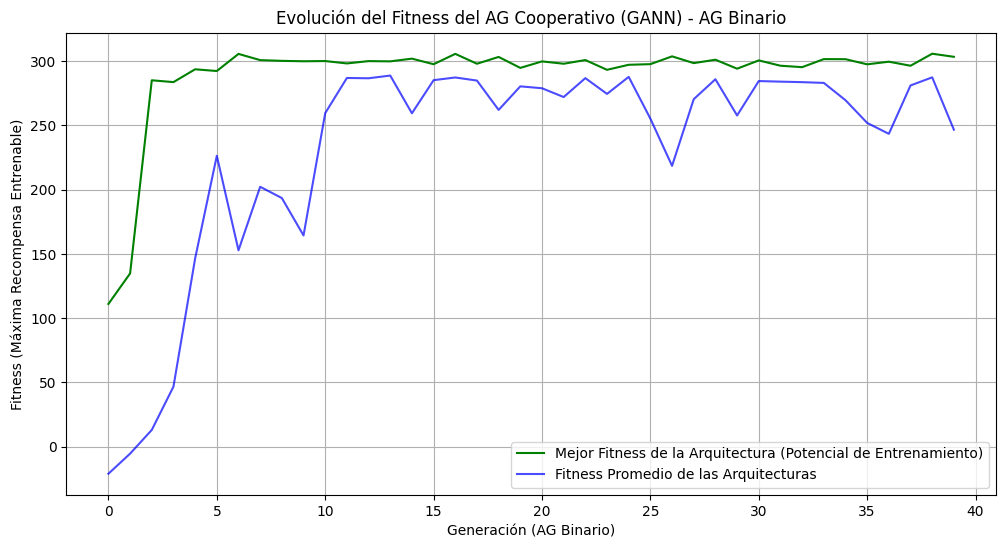

In [20]:
print("\n--- RESULTADOS FINALES --- ")
print(f"Mejor Fitness Global: {best_fitness:.2f}")
if best_arch:
    max_h = decodificar_neuronas_ocultas(best_arch)
    print(f"Mejor Arquitectura (H): {max_h} neuronas ocultas")
    print(f"Gen Binario: {best_arch}")

# Gráfico de Evolución del AG Binario (Diseño de Arquitectura)
generations = [h['gen'] for h in history]
max_fits = [h['max_fit'] for h in history]
avg_fits = [h['avg_fit'] for h in history]

plt.figure(figsize=(12, 6))
plt.plot(generations, max_fits, label='Mejor Fitness de la Arquitectura (Potencial de Entrenamiento)', color='green')
plt.plot(generations, avg_fits, label='Fitness Promedio de las Arquitecturas', color='blue', alpha=0.7)
plt.title('Evolución del Fitness del AG Cooperativo (GANN) - AG Binario')
plt.xlabel('Generación (AG Binario)')
plt.ylabel('Fitness (Máxima Recompensa Entrenable)')
plt.legend()
plt.grid(True)
plt.show()

Arquitectura: 16 neuronas ocultas

Episodio 1/5... Success | Reward: 295.14 | Pasos: 197


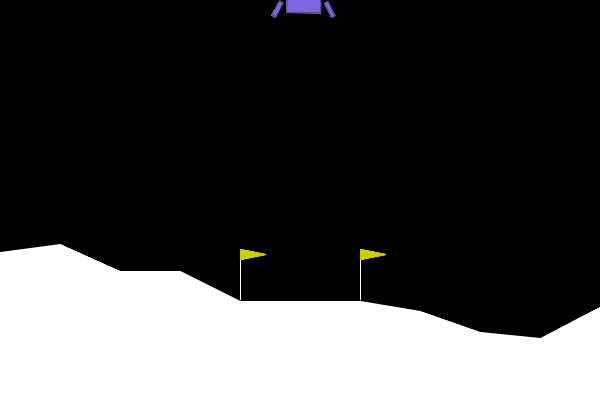

Episodio 2/5... Fail | Reward: 49.77 | Pasos: 500


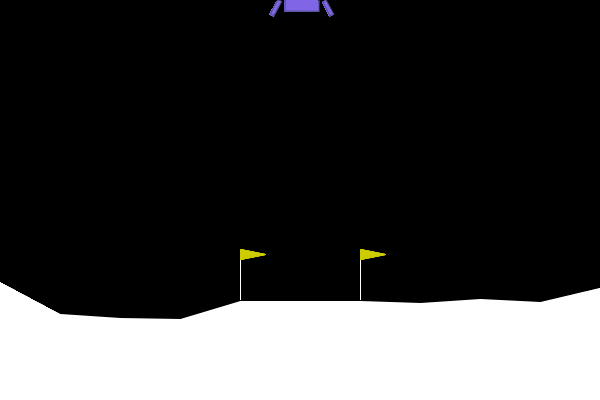

Episodio 3/5... Success | Reward: 254.20 | Pasos: 210


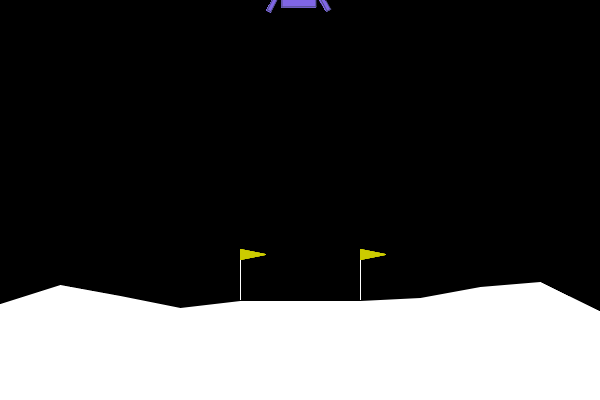

Episodio 4/5... Success | Reward: 271.75 | Pasos: 232


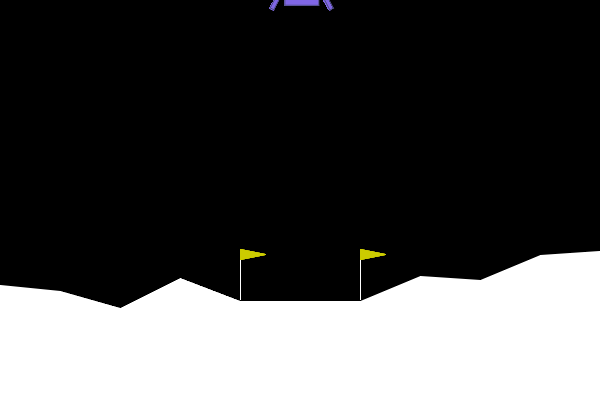

Episodio 5/5... Success | Reward: 266.21 | Pasos: 214


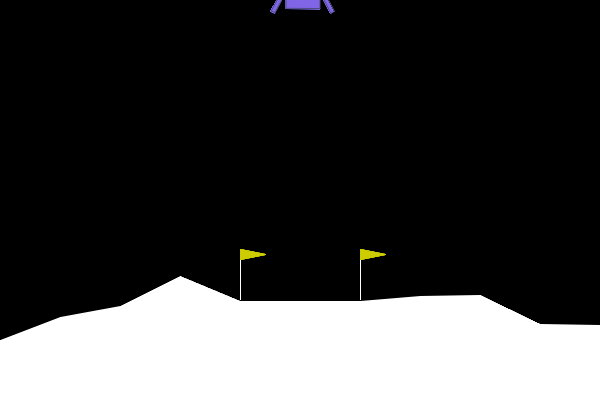

In [21]:
def display_best_individual(best_weights: List[float], best_arch: List[int], num_episodes: int = 5):
    # Obtener parámetros de la red
    H = decodificar_neuronas_ocultas(best_arch)
    print(f"Arquitectura: {H} neuronas ocultas\n")

    # Crear entorno con renderizado
    env = gym.make('LunarLander-v3', render_mode='rgb_array')

    input_size = env.observation_space.shape[0]
    output_size = env.action_space.n
    W1, b1, W2, b2 = decode_real_weights(best_weights, input_size, output_size, H)
    for episode in range(num_episodes):
        observation, info = env.reset()
        episode_reward = 0
        terminated = False
        truncated = False
        steps = 0
        frames = []

        print(f"Episodio {episode + 1}/{num_episodes}...", end=" ")

        while not terminated and not truncated and steps < MAX_STEPS:
            action = forward(observation, W1, b1, W2, b2)
            observation, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward
            steps += 1
            frames.append(env.render())

        # Guardar como GIF
        gif_path = f'/content/episode_{episode+1}.gif'
        imageio.mimsave(gif_path, frames, fps=30)

        # Mostrar resultado
        resultado = "Success" if episode_reward > 200 else "Fail"
        print(f"{resultado} | Reward: {episode_reward:.2f} | Pasos: {steps}")

        # Mostrar GIF en Colab
        display(Image(filename=gif_path))

    env.close()

display_best_individual(best_weights, best_arch, num_episodes=5)